### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [359]:
!pip install numdifftools

In [360]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import laplace
import corner
import numdifftools as nd

In [361]:
# import numdifftools as nd
# H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
# sigma_laplace = np.linalg.inv(H)**0.5

### Solution

In [362]:
data = np.load('hw_data/hw3_data_1.npy')
x = data[:,0]
sigma = data [:,1]
#data

In [363]:
sample_mu = np.sum(x / sigma**2) / np.sum(1/(sigma**2))
sample_sigma = np.sum(1/(sigma)**2)**(-1/2)
print('Sample Mean = ',sample_mu ,'\nStandard Error on the sample mean = ' , sample_sigma)

Sample Mean =  3.9179920346060557 
Standard Error on the sample mean =  0.09481084100510954


In [364]:
#Minimizing the Chi^2 value
def negative_log_likelihood_gaussian(params, x):
    mu, sigma = params
    return np.sum((x - mu)**2 / (2 * sigma**2) + np.log(np.sqrt(2 * np.pi * sigma**2)))
result = sp.optimize.minimize(negative_log_likelihood_gaussian, [np.mean(x), np.std(x, ddof=1)], args=(x,))
mu_fit_g, sigma_fit_g = result.x
print('After optimization the mean turn out to be = ',mu_fit_g)

After optimization the mean turn out to be =  3.937547481513503


In [365]:
f_mu = 1/np.sqrt(np.sum(1/sigma**2))
print('fischer uncertainity of mu = ',f_mu)

fischer uncertainity of mu =  0.09481084100510956


In [366]:
bootstrap_data = np.empty((1000, 50, 2))
np.random.seed(42)
for j in range(1000):
    for i in range(50):
        rnd = np.random.randint(0, 50)
        bootstrap_data[j,i] = data[rnd]        

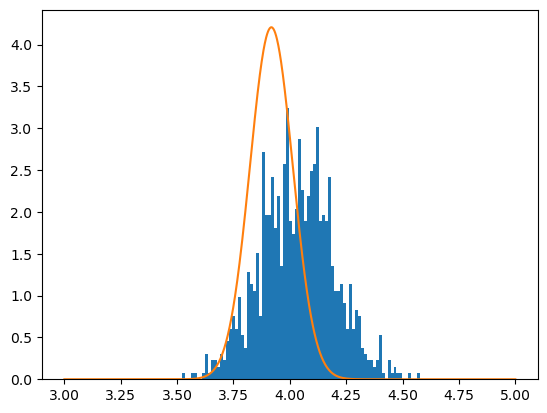

In [380]:
mu_hist_g=[]
for j in range(1000):
    boot_x = bootstrap_data[j][:,0]
    boot_sigma = bootstrap_data[j][:,1]
    result = sp.optimize.minimize(negative_log_likelihood_gaussian, [np.mean(boot_x), np.std(boot_x, ddof=1)], args=(boot_x,))
    mu_fit, sigma_fit = result.x
    mu_hist_g.append(mu_fit)
    
plt.hist(mu_hist_g, bins=80,density=True)
dist_g = norm(loc=sample_mu, scale=sample_sigma)
x_range = np.linspace(3,5,1000)
plt.plot(x_range,dist_g.pdf(x_range))
plt.show()

In [368]:
def negative_log_likelihood_laplace(params, x):
    mu, delta = params
    return np.sum(np.log(2 * delta) + np.abs(x - mu) / delta)
res_l = sp.optimize.minimize(negative_log_likelihood_laplace, [np.median(x), np.mean(np.abs(x - np.median(x)))], args=(x,))
mu_fit_l, delta_fit_l = res_l.x

print('After optimization the mean turns out to be = ',mu_fit_l)

After optimization the mean turns out to be =  4.085141264538312


In [369]:
def log_likelihood_gaussian(mu, sigma, x):
    return -0.5 * np.sum(((x - mu) / sigma)**2 + np.log(2 * np.pi * sigma**2))

def log_likelihood_laplace(mu, delta, x):
    return -np.sum(np.log(2 * delta) + np.abs(x - mu) / delta)
    
def compute_aic(log_likelihood, k):
    return 2 * k - 2 * log_likelihood
k=2
aic_g = compute_aic(log_likelihood_gaussian(mu_fit_g, sigma_fit_g, x) , k)
aic_l = compute_aic(log_likelihood_laplace(mu_fit_l, delta_fit_l, x) , k)
#log_likelihood_gaussian(mu_fit_g, sigma_fit_g, x) , log_likelihood_laplace(mu_fit_l, delta_fit_l, x)

In [370]:
print('Lower AIC is favoured \nAIC of Gaussian = ',aic_g,'\nAIC of Laplacian = ',aic_l)

Lower AIC is favoured 
AIC of Gaussian =  315.86537847577375 
AIC of Laplacian =  317.57783235318016


In [371]:
hist_l=np.empty((1000,2))
for j in range(1000):
    boot_x = bootstrap_data[j][:,0]
    boot_sigma = bootstrap_data[j][:,1]
    result = sp.optimize.minimize(negative_log_likelihood_laplace, [np.median(boot_x), np.mean(np.abs(boot_x - np.median(boot_x)))], args=(boot_x,))
    b_mu_fit_l, b_delta_fit_l = result.x
    hist_l[j]=np.array([b_mu_fit_l, b_delta_fit_l])
    
# plt.hist(mu_hist_l, bins=100,density=True)
# dist_l = laplace(loc=sample_mu, scale=sample_sigma)
# x_range = np.linspace(3,5,1000)
# plt.plot(x_range,dist_l.pdf(x_range))
# plt.show()

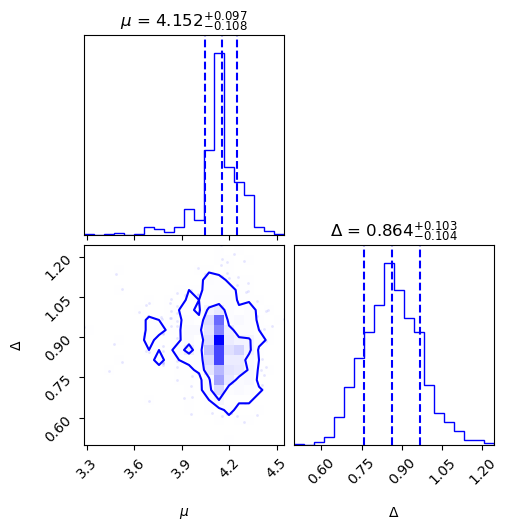

In [372]:
fig = corner.corner(
    hist_l,
    labels=[r"$\mu$", r"$\Delta$"],  # LaTeX-style labels
    quantiles=[0.16, 0.5, 0.84],  # 68% credible interval
    show_titles=True,  # Show best-fit values on 1D marginals
    title_fmt=".3f",  # Format of the titles
    title_kwargs={"fontsize": 12},  # Adjust title font size
    plot_contours=True,  # Show 2D contours
    levels=[0.68, 0.95],  # 68% and 95% levels
    color="blue"  # Set plot color
)


In [373]:
def log_likelihood(params, data):
    mu, delta = params
    return -np.sum(np.log(laplace.pdf(data, loc=mu, scale=delta)))

# Step 3: Define a function to compute the Hessian (second derivatives)
def compute_hessian(log_likelihood, data, params):
    # numdifftools will compute the Hessian (second derivatives) of the log-likelihood function
    hessian = nd.Hessian(lambda p: log_likelihood(p, data))(params)
    return hessian

params_best_fit = [mu_fit_l, delta_fit_l]
hessian_matrix = compute_hessian(log_likelihood, x, params_best_fit)

# Step 7: Invert the Hessian matrix to get the covariance matrix
covariance_matrix = np.linalg.inv(hessian_matrix)

# Step 8: Take the square root of the diagonal to get the Fisher uncertainties
fisher_uncertainties = np.sqrt(np.diag(covariance_matrix))

In [374]:
#Fischer Uncertainities for mean and delta

In [375]:
fisher_uncertainties

array([0.1092248 , 0.08822692])

In [376]:
mu_bootstrap_width = np.std(hist_l[:,0])
delta_bootstrap_width = np.std(hist_l[:,1])

In [377]:
#From Bootstrap Method

In [378]:
mu_bootstrap_width,delta_bootstrap_width

(0.13725405553149622, 0.10496329080263131)